Models the generation of a keypoint heatmap image as a multi-stage generative model:

1) A set of object-frame keypoints $p_O$ is transformed into camera frame according to $p_C = RSp + T$, for $R$ ~ uniform over $SO(3)$ (implemented as random normal 4-vectors normalized into quaternions), $S = diag(s)$ with each of the 3 elements of $s$ from Inverse gamma distributions, and $T$ drawn fron a diagonal normal.

2) Camera-frame keypoints $p_C$ are projected into the (2D) image plane via a perspective projection $p_{Im} = K(\hat{p})$.

3) An image is formed by summing a narrow-width Gaussian at each pixel keypoint location and saturating at 1; at pixel $(u, v)$, $z(u, v) = min(\sum_i{\mathcal{N}(\mu = p_{Im}, \sigma=\Sigma_{pt})}, 0)$.

4) The observed keypoint image is generated by pixelwise Normal draws: $z_{obs}(u, v) = \mathcal{N}(\mu = z(u, v), \sigma=\Sigma_{obs})$.


So the only random choices being made are the pose and size of the box; so I'll try posterior inference of $p(R, T, s | z_{obs})$ with MCMC.

In [2]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from scene_generation.utils.torch_quaternion import quat2mat

import operator
from functools import reduce  # Required in Python 3
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

torch.set_default_tensor_type(torch.FloatTensor)

            Trace Shapes:          
             Param Sites:          
         dimensions_alpha   3      
          dimensions_beta   3      
            Sample Sites:          
               batch dist   |      
                    value 1 |      
            box_quat dist 1 |  4   
                    value 1 |  4   
             box_xyz dist 1 |  3   
                    value 1 |  3   
      box_dimensions dist 1 |  3   
                    value 1 |  3   
box_keypoint_heatmap dist 1 | 32 32
                    value 1 | 32 32
Total Log prob:  tensor(955.3184, grad_fn=<AddBackward0>)
R:  tensor([[ 0.1725, -0.8257,  0.5371],
        [ 0.4676, -0.4113, -0.7824],
        [ 0.8669,  0.3861,  0.3152]])
T:  tensor([[0.0234, 0.0230, 0.8877]])
S:  tensor([[0.4213, 0.3003, 0.4198]], grad_fn=<PowBackward1>)


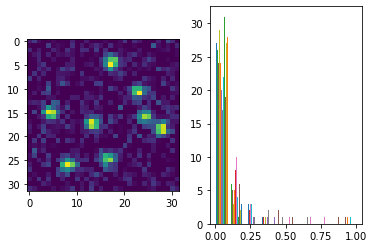

In [3]:
class Box():
    def __init__(self, name, R, t, s):
        # Pose quatxyz in camera frame
        # Dimensions x y z
        assert R.shape[-2:] == (3, 3), pose.shape
        assert s.shape[-1] == 3, s.shape
        assert R.shape[:-2] == t.shape[:-1] and R.shape[:-2] == s.shape[:-1], "Unaligned batch shapes."
        self.batch_shape = tuple(R.shape[:-2])
        self.N_keypoints = 8
        self.name = name
        self.R = R
        self.t = t
        self.s = s

    def generate_keypoints(self):
        # Renders corner keypoints under this box's transformation.
        # Stack pose elements into TF matrix 
        N = prod(self.batch_shape)
        R_flattened = self.R.reshape(N, 3, 3)
        t_flattened = self.t.reshape(N, 3)
        Rt = torch.cat([R_flattened, t_flattened.unsqueeze(-1)], dim=2) # [N,3,4]
        # Make homogenous
        hom_aug = torch.cat([torch.zeros([N, 1, 3]),
                             torch.ones([N, 1, 1])],
                            dim=2).to(Rt.device)
        tf = torch.cat([Rt, hom_aug], dim=1) # [N,4,4]

        pts = torch.tensor(
            np.array([[-1., -1., -1., -1, 1., 1., 1., 1.],
                      [-1., -1., 1., 1., -1., -1., 1., 1.],
                      [-1., 1., -1., 1., -1., 1., -1., 1.]]),
            dtype=self.R.dtype)
        pts = pts.unsqueeze(0).repeat(N, 1, 1)
        pts = pts * self.s.reshape(N, 3, 1).repeat(1, 1, self.N_keypoints) / 2. # [N, 3]
        pts_homog = torch.cat([pts, torch.ones(N, 1, pts.shape[2])], dim=1)
        pts = torch.bmm(tf, pts_homog)[..., :3, :]
        return pts.reshape(self.batch_shape + (3, self.N_keypoints))

    def sample_keypoint_images(self, image_shape, camera_K, temperature=1.0):
        # Project keypoints into UV coordinates, create a "target" image by
        # summing normal distributions at each keypoint location, and
        # sample an observed image.
        assert(camera_K.shape == (3, 3))
        sigma_keypoint = 1.
        sigma_observation = 0.1
        
        N = prod(self.batch_shape)

        # Calculate 3D keypoint locations in camera frame.
        pts = self.generate_keypoints().reshape(N, 3, self.N_keypoints)
        # Project each point into the image plane.
        pts_uv_unnormalized = torch.bmm(camera_K.repeat(N, 1, 1), pts).permute(0, 2, 1) # [N, N_keypoints, 3]
        pts_uv = torch.empty(N, self.N_keypoints, 2)
        pts_uv[..., 0] = pts_uv_unnormalized[..., 0] / pts_uv_unnormalized[..., 2]
        pts_uv[..., 1] = pts_uv_unnormalized[..., 1] / pts_uv_unnormalized[..., 2]
        
        grid_x, grid_y = torch.meshgrid(
            torch.arange(image_shape[0]),
            torch.arange(image_shape[1])
        )
        batched_grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).reshape(1, -1, 2)
        batched_grid = batched_grid.repeat(N, 1, 1)
        
        # Collect output images across the different points.
        peak_heatmaps = [] # (self.batch_size, image_shape[0], image_shape[1]))
        for k in range(self.N_keypoints): # probably could batch this too...
            # Distances to the peak, for each pixel in the image
            # (Repeats pts to be the same size as the flattened batched grid so the
            # batching works out)
            distances_from_peak = torch.sum(
                    (batched_grid - pts_uv[..., k, :].unsqueeze(1).repeat(1, batched_grid.shape[1], 1))**2.,
                axis=-1)
            peak_heatmap = torch.exp(-distances_from_peak / (2. * (sigma_keypoint ** 2.))) + 1E-6 # Avoid numerical issue when normalizing
            peak_heatmap = peak_heatmap.reshape(-1, image_shape[0], image_shape[1])
            peak_heatmaps.append(peak_heatmap)
        
        # Sum up the heatmaps and clamp at one.
        total_heatmap_vals = torch.clamp(torch.stack(peak_heatmaps, axis=-1).sum(axis=-1), 0., 1.)
        heatmap_images = total_heatmap_vals.reshape(self.batch_shape + tuple(image_shape))
        
        # Finally, we can use those to sample a keypoint
        # occurance image.
        with pyro.poutine.scale(scale=1./temperature):
            keypoint_occurance_image = pyro.sample(
                self.name + "_keypoint_heatmap",
                dist.Normal(heatmap_images,
                            sigma_observation).to_event(2))
        return keypoint_occurance_image


    @staticmethod
    def sample(name = "box", batch_size=1):
        with pyro.plate("batch", batch_size):
            quat = pyro.sample(
                name + "_quat",
                dist.Uniform(torch.ones(4)*-1.01,
                             torch.ones(4)*1.01).to_event(1)
            )
            if len(quat.shape) == 1:
                quat = quat.reshape(-1, 4)
            quat = F.normalize(quat, p=2, dim=-1)
            R = quat2mat(quat)

            xyz_mean = torch.zeros(3)
            xyz_mean[2] = 1.
            xyz_scale = torch.ones(3) * 0.1
            xyz = pyro.sample(
                name + "_xyz",
                dist.Normal(xyz_mean, xyz_scale).to_event(1)
            )
            if len(xyz.shape) == 1:
                xyz = xyz.reshape(-1, 3)

            dimensions_alpha = pyro.param(
                "dimensions_alpha", torch.ones(3) * 3.,
                constraint=constraints.positive)
            dimensions_beta = pyro.param(
                "dimensions_beta", torch.ones(3) * 1.,
                constraint=constraints.positive)
            dimensions = pyro.sample(
                name + "_dimensions",
                dist.InverseGamma(dimensions_alpha, dimensions_beta).to_event(1)
            )
            if len(dimensions.shape) == 1:
                dimensions = dimensions.reshape(-1, 3)

        return Box(
            name=name,
            R = R,
            t = xyz,
            s = dimensions
        )

N = 32
default_image_shape = (N, N)
default_camera_K = torch.tensor(
    np.array([[N, 0, N/2],
              [0, N, N/2],
              [0, 0, 1]]),
    dtype=torch.get_default_dtype()
)
def sample_keypoint_image(image_shape=default_image_shape, camera_K=default_camera_K, batch_size=1,
                          temperature=1.0):
    return Box.sample(batch_size=batch_size).sample_keypoint_images(image_shape, camera_K, temperature=temperature)

# Generate a target image that we'll try to recover the pose and shape from.
torch.manual_seed(42)
target_trace = pyro.poutine.trace(sample_keypoint_image).get_trace(batch_size=1)
print(target_trace.format_shapes())
print("Total Log prob: ", target_trace.log_prob_sum())
target_im = target_trace.nodes["_RETURN"]["value"]
# The output image from this system isn't bounded on 0, 1 -- make it so.
# (Hacky, but I'm just trying to come up with an interesting image to
# test the system on.)
target_im = torch.clamp(target_im, 0, 1).cpu().detach()[0, :, :]
target_quat = target_trace.nodes["box_quat"]["value"]
target_R = quat2mat(target_quat)[0, ...]
target_t = target_trace.nodes["box_xyz"]["value"]
target_s = target_trace.nodes["box_dimensions"]["value"]
print("R: ", target_R)
print("T: ", target_t)
print("S: ", target_s)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(target_im.numpy())
plt.subplot(1, 2, 2)
plt.hist(target_im)
plt.show()

In [4]:
# Benchmark
import time
start_time = time.time()
N = 100
for k in range(N):
    dummy_trace = pyro.poutine.trace(sample_keypoint_image).get_trace()
elapsed = time.time() - start_time
print("Did %d iterations in %f seconds: %f/sec" % (N, elapsed, N/elapsed))

Did 100 iterations in 0.384424 seconds: 260.129299/sec


In [16]:
from pyro.infer.mcmc import MCMC, NUTS, RandomWalkKernel

# Now see if we can recover the original image.
def conditioned_model(target_ims, camera_K=default_camera_K, T=1.):
    # Observations are batched, so if a single image got sent in,
    # pad in a single-element batch dimension.
    if len(target_ims.shape) == 2:
        target_ims = target_ims.unsqueeze(0)
    batch_size = target_ims.shape[0]
    conditioned_model = pyro.poutine.condition(
        sample_keypoint_image,
        data={"box_keypoint_heatmap": target_ims}
    )
    return conditioned_model(
        image_shape=target_ims.shape[-2:],
        camera_K=camera_K,
        batch_size=batch_size,
        temperature=T
    )

num_samples = 1000

# This runs vanilla MCMC on this energy landscape.
#initial_values = {key: site["value"] for key, site in target_trace.nodes.items() if site["type"] is "sample"}
initial_values = {}
temperature = prod(target_im.shape)*100
init_params, potential_fn, transforms, _ = pyro.infer.mcmc.util.initialize_model(
    conditioned_model, model_kwargs={"target_ims": target_im, "T": temperature},
    init_strategy=pyro.infer.autoguide.init_to_value(values=initial_values))
mcmc_kernel = RandomWalkKernel(potential_fn=potential_fn, transforms=transforms, variance=0.1)
#mcmc_kernel = NUTS(potential_fn=potential_fn, transforms=transforms)
mcmc = MCMC(mcmc_kernel,
            initial_params=init_params,
            num_samples=num_samples,
            num_chains=1)
mcmc.run(target_im)
mcmc.summary(prob=0.5)

Sample: 100%|██████████| 2000/2000 [00:20, 95.53it/s, acc. prob=0.452]


                         mean       std    median     25.0%     75.0%     n_eff     r_hat
      box_quat[0,0]      0.26      0.52      0.41      0.41      0.94      2.55      2.44
      box_quat[0,1]     -0.72      0.15     -0.77     -0.88     -0.76      3.78      1.62
      box_quat[0,2]     -0.37      0.40     -0.29     -0.41      0.08      2.80      1.99
      box_quat[0,3]      0.52      0.33      0.62      0.62      0.93      6.42      1.11
       box_xyz[0,0]      0.00      0.10     -0.01     -0.07      0.05     91.72      1.00
       box_xyz[0,1]      0.01      0.09      0.01     -0.01      0.10    120.55      1.00
       box_xyz[0,2]      1.00      0.09      1.01      0.97      1.09    112.13      1.03
box_dimensions[0,0]      0.33      0.12      0.33      0.15      0.34      4.48      1.59
box_dimensions[0,1]      0.61      0.39      0.59      0.08      0.61      3.32      1.90
box_dimensions[0,2]      0.39      0.24      0.30      0.16      0.32      7.03      1.01



Text(0.5, 0, 'Step')

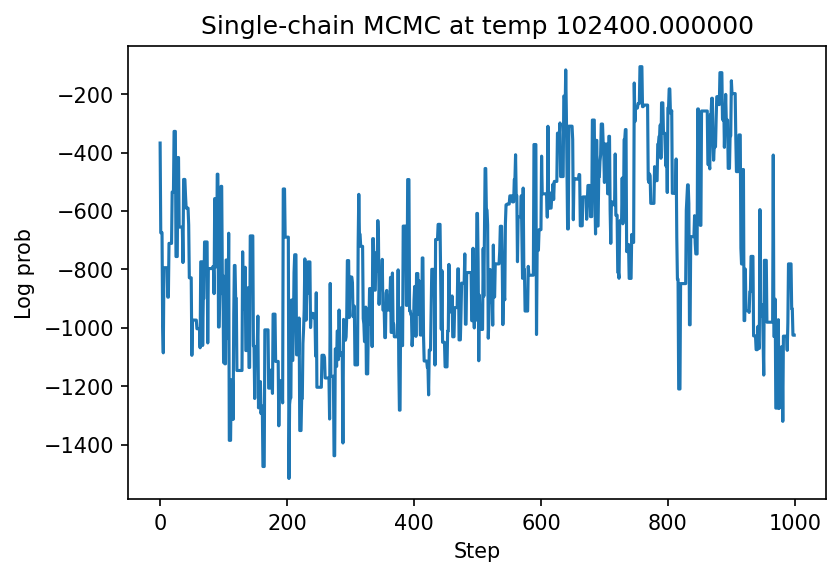

In [17]:
# Inspect MCMC samples -- extract each image for animation, and get scores.
images = []
scores = []
samples = mcmc.get_samples()
for k in range(num_samples):
    data = {key: samples[key][k, ...] for key in samples.keys()}
    images.append(pyro.poutine.condition(sample_keypoint_image, data)(target_im.shape, default_camera_K)[0, :, :])
    scores.append(pyro.poutine.trace(pyro.poutine.condition(conditioned_model, data)).get_trace(target_im).log_prob_sum())
plt.plot(scores)
plt.title("Single-chain MCMC at temp %f" % temperature)
plt.ylabel("Log prob")
plt.xlabel("Step")

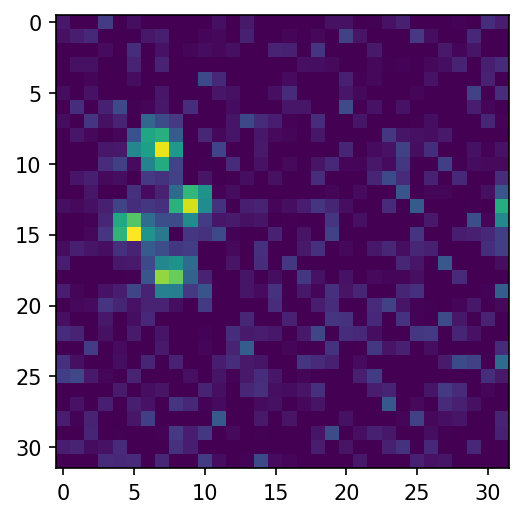

In [18]:
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

num_frames = min(120, len(images))
step = int(len(images)/num_frames)
sub_images = images[0::step]
def animate(t):
    plt.cla()
    plt.imshow(sub_images[t], vmin=0., vmax=1.)
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sub_images))
anim.save('animation.gif', writer='imagemagick', fps=10)
anim

In [21]:
# Custom written parallel tempered MCMC.
# Wish I could do this within the Pyro API, but the organization of their MCMC doesn't make this easy.

temperatures = np.geomspace(1., prod(target_im.shape)*1000, 3)
chains_per_temperature = 1 # this is implemented using the batching in my model; not general-purpose
num_samples = 5000
warmup_steps = int(num_samples/2)
target_im_batched = target_im.unsqueeze(0).repeat((chains_per_temperature, 1, 1))
initial_values = {}

# Prep the kernel for each temperature
kernels = []
samples_by_temp = [] # Strive for same format as MCMC samples
curr_params = []
transforms_by_temp = []
curr_param_scores = torch.empty((len(temperatures), chains_per_temperature))
#initial_values = {key: site["value"].repeat_interleave(chains_per_temperature, dim=0) for key, site in target_trace.nodes.items() if site["type"] is "sample"}
#initial_values["batch"] = torch.range(0, chains_per_temperature-1)
initial_values = {}
for temp in temperatures:
    # TODO: temperature is likely not entering in the theoretically correct way here
    model_kwargs = {"target_ims": target_im.unsqueeze(0).repeat((chains_per_temperature, 1, 1)), "T": temp}
    init_params, potential_fn, transforms, _ = pyro.infer.mcmc.util.initialize_model(
        conditioned_model, model_kwargs=model_kwargs,
        init_strategy=pyro.infer.autoguide.init_to_value(values=initial_values))
    mcmc_kernel = RandomWalkKernel(potential_fn=potential_fn, transforms=transforms, variance=0.1)
    mcmc_kernel.setup(warmup_steps=warmup_steps, kwargs=model_kwargs)
    kernels.append(mcmc_kernel)
    curr_params.append(init_params)
    samples_by_temp.append({key: [value] for key, value in init_params.items()})
    transforms_by_temp.append(transforms)
    

# And grab a potential fn reporting unscaled log probs
model_kwargs = {"target_ims": target_im, "T": 1.}
_, unscaled_potential_fn, _, _ = pyro.infer.mcmc.util.initialize_model(
    conditioned_model, model_kwargs=model_kwargs,
    init_strategy=pyro.infer.autoguide.init_to_value(values=initial_values))

k_boltzmann = 1/4000. # this doesn't have to be the *real* horrible boltzmann constant, does it?

num_swaps_accepted = 0
num_swaps_rejected = 0
for step_k in range(num_samples):
    print("Sample %d/%d" % (step_k, num_samples))
    # Step all of the kernels.
    for temp_k, temp in enumerate(temperatures):
        curr_params[temp_k] = kernels[temp_k].sample(curr_params[temp_k])
        # This involves re-running potential fns, but I hope it isn't that expensive
        # compared to running the full model forward.
        for chain_k in range(chains_per_temperature):
            chain_params = {key: value[chain_k, ...] for key, value in curr_params[temp_k].items()}
            curr_param_scores[temp_k, chain_k] = -unscaled_potential_fn(chain_params)
    # For each temperature, pick a random one-to-one mapping between the chains of the current
    # and higher temperature, and randomly swap those pairs with an MH accept criteria.
    # (Referencing Eq 2.2 of http://www.math.pitt.edu/~cbsg/Materials/Earl_ParallelTempering.pdf)
    for temp_k in range(len(temperatures) - 1):
        permutation = np.random.permutation(chains_per_temperature)
        for lower_chain_k, upper_chain_k in enumerate(permutation):
            lower_log_prob = curr_param_scores[temp_k][lower_chain_k]
            lower_beta = 1./(k_boltzmann*temperatures[temp_k])
            upper_log_prob = curr_param_scores[temp_k+1][upper_chain_k]
            upper_beta = 1./(k_boltzmann*temperatures[temp_k+1])
            accept_prob = torch.exp((-upper_log_prob - (-lower_log_prob))*
                                    (upper_beta - lower_beta))
            accept_prob = torch.clamp(accept_prob, max=1.0)
            #print("Probs %f, %f, betas %f, %f, a %f" % (lower_log_prob, upper_log_prob, lower_beta, upper_beta, accept_prob))
            x = pyro.sample("accept_%d_%d_swap_%d_%d" % (step_k, temp_k, lower_chain_k, upper_chain_k),
                            dist.Uniform(0., 1.))
            if x <= accept_prob:
                print("Accepted: lower energy %f / beta %f, upper energy %f / beta %f" % (lower_log_prob, lower_beta, upper_log_prob, upper_beta))
                num_swaps_accepted += 1
                for key in curr_params[temp_k].keys():
                    temp_param = curr_params[temp_k][key][lower_chain_k, ...].clone()
                    curr_params[temp_k][key][lower_chain_k, ...] = curr_params[temp_k + 1][key][upper_chain_k, ...].clone()
                    curr_params[temp_k + 1][key][upper_chain_k, ...] = temp_param
            else:
                num_swaps_rejected += 1
    # Record resulting samples for this step.
    for temp_k in range(len(temperatures)):
        for key, value in curr_params[temp_k].items():
            samples_by_temp[temp_k][key].append(value.clone())
# Fix up samples: stack them along batch dimension and inverse transform those
# with corresponding transforms.
for temp_k in range(len(temperatures)):
    for key in samples_by_temp[temp_k].keys():
        samples_by_temp[temp_k][key] = torch.stack(samples_by_temp[temp_k][key], dim=0)
    for name, transform in transforms_by_temp[temp_k].items():
        samples_by_temp[temp_k][name] = transform.inv(samples_by_temp[temp_k][name])
print("Accepted %d, Rejected %d = %f percent swaps accepted" % (num_swaps_accepted, num_swaps_rejected, num_swaps_accepted / (num_swaps_accepted + num_swaps_rejected)))

Sample 0/5000
Sample 1/5000
Sample 2/5000
Sample 3/5000
Sample 4/5000
Sample 5/5000
Sample 6/5000
Sample 7/5000
Accepted: lower energy -311.762115 / beta 4000.000000, upper energy -305.388214 / beta 3.952847
Sample 8/5000
Sample 9/5000
Sample 10/5000
Sample 11/5000
Sample 12/5000
Sample 13/5000
Sample 14/5000
Accepted: lower energy -261.335175 / beta 4000.000000, upper energy -249.884842 / beta 3.952847
Sample 15/5000
Sample 16/5000
Sample 17/5000
Sample 18/5000
Sample 19/5000
Sample 20/5000
Sample 21/5000
Sample 22/5000
Sample 23/5000
Sample 24/5000
Sample 25/5000
Accepted: lower energy -388.151428 / beta 3.952847, upper energy -341.353485 / beta 0.003906
Sample 26/5000
Sample 27/5000
Accepted: lower energy -304.657532 / beta 3.952847, upper energy -77.897270 / beta 0.003906
Sample 28/5000
Accepted: lower energy -708.371521 / beta 3.952847, upper energy -295.846405 / beta 0.003906
Sample 29/5000
Sample 30/5000
Sample 31/5000
Sample 32/5000
Sample 33/5000
Sample 34/5000
Sample 35/5000


Accepted: lower energy -535.824768 / beta 3.952847, upper energy -253.857834 / beta 0.003906
Sample 323/5000
Sample 324/5000
Sample 325/5000
Sample 326/5000
Sample 327/5000
Sample 328/5000
Sample 329/5000
Sample 330/5000
Sample 331/5000
Sample 332/5000
Sample 333/5000
Sample 334/5000
Sample 335/5000
Sample 336/5000
Sample 337/5000
Sample 338/5000
Sample 339/5000
Sample 340/5000
Sample 341/5000
Sample 342/5000
Sample 343/5000
Sample 344/5000
Sample 345/5000
Sample 346/5000
Sample 347/5000
Sample 348/5000
Sample 349/5000
Sample 350/5000
Sample 351/5000
Sample 352/5000
Sample 353/5000
Sample 354/5000
Sample 355/5000
Sample 356/5000
Sample 357/5000
Sample 358/5000
Sample 359/5000
Sample 360/5000
Sample 361/5000
Sample 362/5000
Sample 363/5000
Sample 364/5000
Sample 365/5000
Sample 366/5000
Sample 367/5000
Sample 368/5000
Sample 369/5000
Sample 370/5000
Sample 371/5000
Sample 372/5000
Sample 373/5000
Sample 374/5000
Sample 375/5000
Sample 376/5000
Sample 377/5000
Sample 378/5000
Sample 379/

Sample 813/5000
Sample 814/5000
Sample 815/5000
Sample 816/5000
Sample 817/5000
Sample 818/5000
Sample 819/5000
Sample 820/5000
Sample 821/5000
Sample 822/5000
Sample 823/5000
Sample 824/5000
Sample 825/5000
Sample 826/5000
Sample 827/5000
Sample 828/5000
Sample 829/5000
Sample 830/5000
Sample 831/5000
Sample 832/5000
Sample 833/5000
Sample 834/5000
Sample 835/5000
Sample 836/5000
Sample 837/5000
Sample 838/5000
Sample 839/5000
Sample 840/5000
Sample 841/5000
Sample 842/5000
Sample 843/5000
Sample 844/5000
Sample 845/5000
Sample 846/5000
Sample 847/5000
Sample 848/5000
Sample 849/5000
Sample 850/5000
Sample 851/5000
Sample 852/5000
Sample 853/5000
Sample 854/5000
Sample 855/5000
Sample 856/5000
Sample 857/5000
Sample 858/5000
Sample 859/5000
Sample 860/5000
Sample 861/5000
Sample 862/5000
Sample 863/5000
Sample 864/5000
Sample 865/5000
Sample 866/5000
Sample 867/5000
Sample 868/5000
Sample 869/5000
Sample 870/5000
Sample 871/5000
Sample 872/5000
Sample 873/5000
Sample 874/5000
Sample 8

Sample 1191/5000
Sample 1192/5000
Sample 1193/5000
Accepted: lower energy -720.647339 / beta 3.952847, upper energy -661.020020 / beta 0.003906
Sample 1194/5000
Sample 1195/5000
Sample 1196/5000
Sample 1197/5000
Accepted: lower energy -1137.008789 / beta 3.952847, upper energy -770.187622 / beta 0.003906
Sample 1198/5000
Sample 1199/5000
Sample 1200/5000
Sample 1201/5000
Sample 1202/5000
Sample 1203/5000
Accepted: lower energy -750.757507 / beta 3.952847, upper energy -751.243958 / beta 0.003906
Sample 1204/5000
Accepted: lower energy -1035.172852 / beta 3.952847, upper energy -750.757507 / beta 0.003906
Sample 1205/5000
Sample 1206/5000
Sample 1207/5000
Sample 1208/5000
Sample 1209/5000
Sample 1210/5000
Sample 1211/5000
Sample 1212/5000
Accepted: lower energy -936.672546 / beta 3.952847, upper energy -845.654297 / beta 0.003906
Sample 1213/5000
Accepted: lower energy -845.654297 / beta 3.952847, upper energy -769.179016 / beta 0.003906
Sample 1214/5000
Sample 1215/5000
Sample 1216/500

Sample 1451/5000
Sample 1452/5000
Sample 1453/5000
Sample 1454/5000
Sample 1455/5000
Sample 1456/5000
Sample 1457/5000
Accepted: lower energy -1051.572998 / beta 3.952847, upper energy -974.580994 / beta 0.003906
Sample 1458/5000
Sample 1459/5000
Accepted: lower energy -893.639832 / beta 3.952847, upper energy -573.575256 / beta 0.003906
Sample 1460/5000
Sample 1461/5000
Sample 1462/5000
Sample 1463/5000
Sample 1464/5000
Sample 1465/5000
Sample 1466/5000
Sample 1467/5000
Accepted: lower energy -721.596436 / beta 3.952847, upper energy -631.117188 / beta 0.003906
Sample 1468/5000
Sample 1469/5000
Sample 1470/5000
Sample 1471/5000
Sample 1472/5000
Sample 1473/5000
Sample 1474/5000
Sample 1475/5000
Sample 1476/5000
Sample 1477/5000
Sample 1478/5000
Sample 1479/5000
Sample 1480/5000
Accepted: lower energy -788.456848 / beta 3.952847, upper energy -777.666077 / beta 0.003906
Sample 1481/5000
Sample 1482/5000
Accepted: lower energy -851.205627 / beta 3.952847, upper energy -251.659286 / beta

Sample 1695/5000
Sample 1696/5000
Sample 1697/5000
Sample 1698/5000
Accepted: lower energy -1188.990845 / beta 3.952847, upper energy -1055.562378 / beta 0.003906
Sample 1699/5000
Sample 1700/5000
Sample 1701/5000
Sample 1702/5000
Sample 1703/5000
Accepted: lower energy -1140.775757 / beta 3.952847, upper energy -1068.237915 / beta 0.003906
Sample 1704/5000
Sample 1705/5000
Sample 1706/5000
Sample 1707/5000
Sample 1708/5000
Sample 1709/5000
Sample 1710/5000
Sample 1711/5000
Sample 1712/5000
Sample 1713/5000
Sample 1714/5000
Sample 1715/5000
Sample 1716/5000
Sample 1717/5000
Sample 1718/5000
Sample 1719/5000
Sample 1720/5000
Sample 1721/5000
Sample 1722/5000
Sample 1723/5000
Sample 1724/5000
Sample 1725/5000
Sample 1726/5000
Sample 1727/5000
Sample 1728/5000
Sample 1729/5000
Sample 1730/5000
Sample 1731/5000
Accepted: lower energy -666.497192 / beta 3.952847, upper energy -658.591431 / beta 0.003906
Sample 1732/5000
Accepted: lower energy -1024.252197 / beta 3.952847, upper energy -871.

Sample 1939/5000
Sample 1940/5000
Sample 1941/5000
Accepted: lower energy -1171.593628 / beta 3.952847, upper energy -1058.366943 / beta 0.003906
Sample 1942/5000
Sample 1943/5000
Accepted: lower energy -1237.082886 / beta 3.952847, upper energy -1171.593628 / beta 0.003906
Sample 1944/5000
Sample 1945/5000
Sample 1946/5000
Sample 1947/5000
Sample 1948/5000
Accepted: lower energy -760.461731 / beta 3.952847, upper energy -708.005981 / beta 0.003906
Sample 1949/5000
Sample 1950/5000
Sample 1951/5000
Accepted: lower energy -1397.713501 / beta 3.952847, upper energy -760.461731 / beta 0.003906
Sample 1952/5000
Sample 1953/5000
Accepted: lower energy -1085.414795 / beta 3.952847, upper energy -947.275452 / beta 0.003906
Sample 1954/5000
Sample 1955/5000
Sample 1956/5000
Accepted: lower energy -929.411377 / beta 3.952847, upper energy -644.664978 / beta 0.003906
Sample 1957/5000
Sample 1958/5000
Sample 1959/5000
Sample 1960/5000
Sample 1961/5000
Sample 1962/5000
Accepted: lower energy -1115

Sample 2221/5000
Sample 2222/5000
Sample 2223/5000
Sample 2224/5000
Sample 2225/5000
Sample 2226/5000
Sample 2227/5000
Sample 2228/5000
Sample 2229/5000
Sample 2230/5000
Sample 2231/5000
Sample 2232/5000
Sample 2233/5000
Sample 2234/5000
Sample 2235/5000
Sample 2236/5000
Sample 2237/5000
Sample 2238/5000
Sample 2239/5000
Sample 2240/5000
Sample 2241/5000
Sample 2242/5000
Sample 2243/5000
Sample 2244/5000
Sample 2245/5000
Sample 2246/5000
Sample 2247/5000
Sample 2248/5000
Sample 2249/5000
Sample 2250/5000
Sample 2251/5000
Accepted: lower energy -755.674133 / beta 3.952847, upper energy -751.002625 / beta 0.003906
Sample 2252/5000
Sample 2253/5000
Sample 2254/5000
Accepted: lower energy -947.491699 / beta 3.952847, upper energy -755.674133 / beta 0.003906
Sample 2255/5000
Accepted: lower energy -556.318481 / beta 3.952847, upper energy -538.716858 / beta 0.003906
Sample 2256/5000
Accepted: lower energy -850.346252 / beta 3.952847, upper energy -414.972656 / beta 0.003906
Sample 2257/5000

Sample 2494/5000
Sample 2495/5000
Sample 2496/5000
Sample 2497/5000
Sample 2498/5000
Sample 2499/5000
Sample 2500/5000
Accepted: lower energy -444.303650 / beta 3.952847, upper energy -440.745667 / beta 0.003906
Sample 2501/5000
Sample 2502/5000
Sample 2503/5000
Sample 2504/5000
Sample 2505/5000
Sample 2506/5000
Sample 2507/5000
Sample 2508/5000
Accepted: lower energy -440.745667 / beta 3.952847, upper energy -438.559143 / beta 0.003906
Sample 2509/5000
Sample 2510/5000
Sample 2511/5000
Sample 2512/5000
Sample 2513/5000
Sample 2514/5000
Accepted: lower energy -514.561035 / beta 3.952847, upper energy -427.544159 / beta 0.003906
Sample 2515/5000
Sample 2516/5000
Sample 2517/5000
Accepted: lower energy -427.544159 / beta 3.952847, upper energy -251.153442 / beta 0.003906
Sample 2518/5000
Sample 2519/5000
Sample 2520/5000
Sample 2521/5000
Sample 2522/5000
Sample 2523/5000
Sample 2524/5000
Sample 2525/5000
Sample 2526/5000
Sample 2527/5000
Sample 2528/5000
Sample 2529/5000
Sample 2530/5000

Sample 2744/5000
Sample 2745/5000
Sample 2746/5000
Sample 2747/5000
Accepted: lower energy -458.951019 / beta 3.952847, upper energy -346.439423 / beta 0.003906
Sample 2748/5000
Sample 2749/5000
Sample 2750/5000
Sample 2751/5000
Sample 2752/5000
Sample 2753/5000
Sample 2754/5000
Sample 2755/5000
Sample 2756/5000
Accepted: lower energy -383.153198 / beta 3.952847, upper energy -350.255432 / beta 0.003906
Sample 2757/5000
Sample 2758/5000
Sample 2759/5000
Accepted: lower energy -357.546326 / beta 3.952847, upper energy -277.606567 / beta 0.003906
Sample 2760/5000
Sample 2761/5000
Sample 2762/5000
Sample 2763/5000
Sample 2764/5000
Sample 2765/5000
Sample 2766/5000
Sample 2767/5000
Sample 2768/5000
Sample 2769/5000
Sample 2770/5000
Sample 2771/5000
Sample 2772/5000
Sample 2773/5000
Sample 2774/5000
Sample 2775/5000
Sample 2776/5000
Sample 2777/5000
Sample 2778/5000
Sample 2779/5000
Sample 2780/5000
Sample 2781/5000
Sample 2782/5000
Sample 2783/5000
Sample 2784/5000
Sample 2785/5000
Sample 

Sample 3035/5000
Sample 3036/5000
Sample 3037/5000
Sample 3038/5000
Sample 3039/5000
Accepted: lower energy -1080.609985 / beta 3.952847, upper energy -432.177368 / beta 0.003906
Sample 3040/5000
Sample 3041/5000
Sample 3042/5000
Sample 3043/5000
Accepted: lower energy -788.204590 / beta 3.952847, upper energy -489.652222 / beta 0.003906
Sample 3044/5000
Accepted: lower energy -829.580322 / beta 3.952847, upper energy -788.204590 / beta 0.003906
Sample 3045/5000
Accepted: lower energy -788.204590 / beta 3.952847, upper energy -637.676331 / beta 0.003906
Sample 3046/5000
Sample 3047/5000
Accepted: lower energy -920.519531 / beta 3.952847, upper energy -788.204590 / beta 0.003906
Sample 3048/5000
Sample 3049/5000
Accepted: lower energy -788.204590 / beta 3.952847, upper energy -758.882874 / beta 0.003906
Sample 3050/5000
Sample 3051/5000
Sample 3052/5000
Accepted: lower energy -735.727966 / beta 3.952847, upper energy -662.860229 / beta 0.003906
Sample 3053/5000
Sample 3054/5000
Sample 3

Sample 3337/5000
Sample 3338/5000
Sample 3339/5000
Sample 3340/5000
Sample 3341/5000
Sample 3342/5000
Sample 3343/5000
Sample 3344/5000
Sample 3345/5000
Sample 3346/5000
Sample 3347/5000
Sample 3348/5000
Sample 3349/5000
Sample 3350/5000
Sample 3351/5000
Accepted: lower energy -1153.152832 / beta 3.952847, upper energy -1142.177612 / beta 0.003906
Sample 3352/5000
Sample 3353/5000
Sample 3354/5000
Sample 3355/5000
Sample 3356/5000
Accepted: lower energy -686.077454 / beta 3.952847, upper energy -581.040039 / beta 0.003906
Sample 3357/5000
Sample 3358/5000
Sample 3359/5000
Sample 3360/5000
Sample 3361/5000
Sample 3362/5000
Accepted: lower energy -1139.478638 / beta 3.952847, upper energy -876.207642 / beta 0.003906
Sample 3363/5000
Accepted: lower energy -876.207642 / beta 3.952847, upper energy -652.778442 / beta 0.003906
Sample 3364/5000
Sample 3365/5000
Sample 3366/5000
Sample 3367/5000
Sample 3368/5000
Sample 3369/5000
Sample 3370/5000
Sample 3371/5000
Sample 3372/5000
Sample 3373/5

Sample 3571/5000
Sample 3572/5000
Sample 3573/5000
Sample 3574/5000
Accepted: lower energy -1104.632202 / beta 3.952847, upper energy -981.083008 / beta 0.003906
Sample 3575/5000
Sample 3576/5000
Accepted: lower energy -981.083008 / beta 3.952847, upper energy -856.807800 / beta 0.003906
Sample 3577/5000
Sample 3578/5000
Sample 3579/5000
Accepted: lower energy -856.807800 / beta 3.952847, upper energy -829.578430 / beta 0.003906
Sample 3580/5000
Sample 3581/5000
Sample 3582/5000
Sample 3583/5000
Accepted: lower energy -979.017517 / beta 3.952847, upper energy -793.333618 / beta 0.003906
Sample 3584/5000
Accepted: lower energy -1010.626038 / beta 3.952847, upper energy -979.017517 / beta 0.003906
Sample 3585/5000
Sample 3586/5000
Sample 3587/5000
Sample 3588/5000
Accepted: lower energy -1297.913330 / beta 3.952847, upper energy -1093.974365 / beta 0.003906
Sample 3589/5000
Accepted: lower energy -1093.974365 / beta 3.952847, upper energy -915.172974 / beta 0.003906
Sample 3590/5000
Samp

Sample 3850/5000
Sample 3851/5000
Sample 3852/5000
Sample 3853/5000
Sample 3854/5000
Sample 3855/5000
Sample 3856/5000
Sample 3857/5000
Sample 3858/5000
Sample 3859/5000
Sample 3860/5000
Sample 3861/5000
Sample 3862/5000
Sample 3863/5000
Sample 3864/5000
Sample 3865/5000
Sample 3866/5000
Sample 3867/5000
Sample 3868/5000
Sample 3869/5000
Sample 3870/5000
Sample 3871/5000
Sample 3872/5000
Sample 3873/5000
Sample 3874/5000
Sample 3875/5000
Sample 3876/5000
Sample 3877/5000
Sample 3878/5000
Sample 3879/5000
Sample 3880/5000
Sample 3881/5000
Sample 3882/5000
Sample 3883/5000
Sample 3884/5000
Accepted: lower energy -1132.513428 / beta 3.952847, upper energy -809.892883 / beta 0.003906
Sample 3885/5000
Sample 3886/5000
Accepted: lower energy -711.482361 / beta 3.952847, upper energy -691.572266 / beta 0.003906
Sample 3887/5000
Sample 3888/5000
Sample 3889/5000
Sample 3890/5000
Sample 3891/5000
Accepted: lower energy -1055.497070 / beta 3.952847, upper energy -1010.370422 / beta 0.003906
Samp

Accepted: lower energy -662.214539 / beta 3.952847, upper energy -386.357147 / beta 0.003906
Sample 4152/5000
Sample 4153/5000
Sample 4154/5000
Sample 4155/5000
Sample 4156/5000
Sample 4157/5000
Sample 4158/5000
Sample 4159/5000
Sample 4160/5000
Sample 4161/5000
Sample 4162/5000
Sample 4163/5000
Accepted: lower energy -578.798950 / beta 3.952847, upper energy -431.255951 / beta 0.003906
Sample 4164/5000
Sample 4165/5000
Accepted: lower energy -632.029785 / beta 3.952847, upper energy -600.718201 / beta 0.003906
Sample 4166/5000
Sample 4167/5000
Sample 4168/5000
Sample 4169/5000
Accepted: lower energy -536.564941 / beta 3.952847, upper energy -394.029083 / beta 0.003906
Sample 4170/5000
Accepted: lower energy -741.682129 / beta 3.952847, upper energy -583.456116 / beta 0.003906
Sample 4171/5000
Sample 4172/5000
Sample 4173/5000
Sample 4174/5000
Sample 4175/5000
Sample 4176/5000
Sample 4177/5000
Sample 4178/5000
Sample 4179/5000
Accepted: lower energy -715.505188 / beta 3.952847, upper e

Sample 4405/5000
Accepted: lower energy -1049.235229 / beta 3.952847, upper energy -928.319031 / beta 0.003906
Sample 4406/5000
Sample 4407/5000
Sample 4408/5000
Sample 4409/5000
Sample 4410/5000
Accepted: lower energy -912.594727 / beta 3.952847, upper energy -497.174835 / beta 0.003906
Sample 4411/5000
Accepted: lower energy -778.510742 / beta 3.952847, upper energy -513.611633 / beta 0.003906
Sample 4412/5000
Sample 4413/5000
Sample 4414/5000
Sample 4415/5000
Accepted: lower energy -906.844177 / beta 3.952847, upper energy -582.814697 / beta 0.003906
Sample 4416/5000
Sample 4417/5000
Sample 4418/5000
Sample 4419/5000
Sample 4420/5000
Accepted: lower energy -1029.272339 / beta 3.952847, upper energy -716.269775 / beta 0.003906
Sample 4421/5000
Sample 4422/5000
Sample 4423/5000
Accepted: lower energy -1005.614563 / beta 3.952847, upper energy -931.317383 / beta 0.003906
Sample 4424/5000
Accepted: lower energy -931.317383 / beta 3.952847, upper energy -902.386597 / beta 0.003906
Sample

Sample 4663/5000
Sample 4664/5000
Sample 4665/5000
Accepted: lower energy -1214.754517 / beta 3.952847, upper energy -636.762695 / beta 0.003906
Sample 4666/5000
Sample 4667/5000
Sample 4668/5000
Accepted: lower energy -668.720886 / beta 3.952847, upper energy -551.823914 / beta 0.003906
Sample 4669/5000
Accepted: lower energy -887.142090 / beta 3.952847, upper energy -668.720886 / beta 0.003906
Sample 4670/5000
Sample 4671/5000
Sample 4672/5000
Sample 4673/5000
Accepted: lower energy -797.355408 / beta 3.952847, upper energy -546.434814 / beta 0.003906
Sample 4674/5000
Accepted: lower energy -822.461731 / beta 3.952847, upper energy -797.355408 / beta 0.003906
Sample 4675/5000
Sample 4676/5000
Sample 4677/5000
Sample 4678/5000
Sample 4679/5000
Sample 4680/5000
Sample 4681/5000
Sample 4682/5000
Sample 4683/5000
Sample 4684/5000
Sample 4685/5000
Sample 4686/5000
Sample 4687/5000
Sample 4688/5000
Sample 4689/5000
Sample 4690/5000
Sample 4691/5000
Sample 4692/5000
Sample 4693/5000
Sample 

Accepted: lower energy -846.650635 / beta 3.952847, upper energy -822.542236 / beta 0.003906
Sample 4904/5000
Sample 4905/5000
Sample 4906/5000
Sample 4907/5000
Sample 4908/5000
Sample 4909/5000
Sample 4910/5000
Sample 4911/5000
Sample 4912/5000
Sample 4913/5000
Sample 4914/5000
Sample 4915/5000
Sample 4916/5000
Sample 4917/5000
Sample 4918/5000
Sample 4919/5000
Sample 4920/5000
Sample 4921/5000
Sample 4922/5000
Sample 4923/5000
Sample 4924/5000
Sample 4925/5000
Sample 4926/5000
Sample 4927/5000
Sample 4928/5000
Sample 4929/5000
Sample 4930/5000
Sample 4931/5000
Sample 4932/5000
Sample 4933/5000
Sample 4934/5000
Sample 4935/5000
Sample 4936/5000
Sample 4937/5000
Sample 4938/5000
Sample 4939/5000
Sample 4940/5000
Sample 4941/5000
Sample 4942/5000
Sample 4943/5000
Sample 4944/5000
Sample 4945/5000
Sample 4946/5000
Sample 4947/5000
Sample 4948/5000
Accepted: lower energy -1122.362427 / beta 3.952847, upper energy -959.410400 / beta 0.003906
Sample 4949/5000
Sample 4950/5000
Sample 4951/50

Done with temp  0
Done with temp  1
Done with temp  2


Text(0.5, 1.0, 'Score 205.562546')

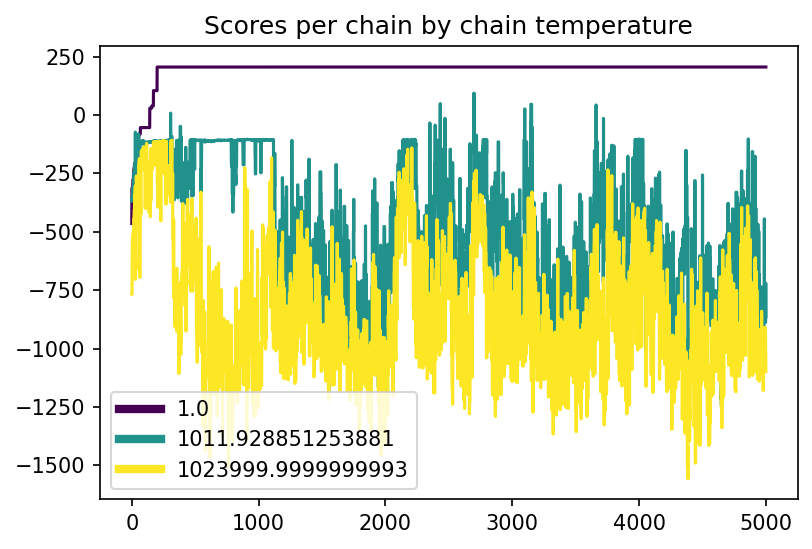

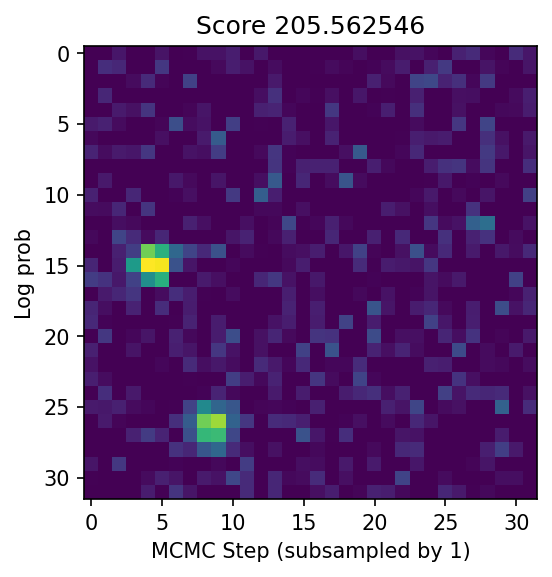

In [22]:
# Inspect resulting samples -- extract each image for animation, and get scores.
from matplotlib.lines import Line2D
images_by_temp = {}
scores_by_temp = {}
best_score = -np.infty
best_im = None
cmap = plt.get_cmap("viridis")
custom_lines = []

subsample_by = 1
for temp_k, (samples, temp) in enumerate(zip(samples_by_temp, temperatures)):
    these_scores = []
    these_images = []
    for chain_k in range(chains_per_temperature):
        images = []
        scores = []
        for k in range(0, num_samples, subsample_by):
            data = {key: samples[key][k, chain_k, ...] for key in samples.keys()}
            images.append(pyro.poutine.condition(sample_keypoint_image, data)(target_im.shape, default_camera_K)[0, :, :].detach().numpy())
            scores.append(pyro.poutine.trace(pyro.poutine.condition(conditioned_model, data)).get_trace(target_im).log_prob_sum().item())
            if scores[-1] >= best_score:
                best_score = scores[-1]
                best_im = images[-1]
        these_images.append(images)
        these_scores.append(scores)
    images_by_temp[temp] = these_images
    scores_by_temp[temp] = np.array(these_scores)
    color = cmap(float(temp_k)/(len(temperatures)-1))
    plt.plot(scores_by_temp[temp].T, c=color)
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    print("Done with temp ", temp_k)
plt.title("Scores per chain by chain temperature")
plt.legend(custom_lines, temperatures)
plt.figure()
plt.imshow(best_im, vmin=0., vmax=1.)
plt.xlabel("MCMC Step (subsampled by %d)" % subsample_by)
plt.ylabel("Log prob")
plt.title("Score %f" % best_score)